In [1]:
import os
from tqdm import tqdm
import multiprocessing
from rdkit.Chem.inchi import *
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
import urllib
import pandas as pd
import numpy as np
from load_data import SMRTDataset, SMRTDatasetRetained, MetabobaseDataset, RikenDataset, MassBank1Dataset
import torch
from torch.utils.data import random_split
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool
from functools import partial
from rdkit.Chem.inchi import *
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
import urllib
import pandas as pd
import numpy as np
from load_data import SMRTDataset, SMRTDatasetRetained, MetabobaseDataset, RikenDataset, MassBank1Dataset
import torch
from torch.utils.data import random_split
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
def ROC(df, threshold):
    TPR=[]
    FPR=[]

    df['pos'] = df['inchi']==df['inchi_true']
    P = len(df[df.pos==True])

    N = len(df[df.pos==False])
    print(P, N)
    for thresh in tqdm(threshold):
        df['pos_thresh'] = df['re']<thresh
        TP = len(df[(df['pos']==True)&(df['pos_thresh']==True)])
        FP = len(df[(df['pos']==False)&(df['pos_thresh']==True)])
        TPR.append(TP/P)
        FPR.append(FP/N)
    print ('Best threshold:', threshold[np.argmax(np.array(TPR)-np.array(FPR))])
    return (TPR, FPR, threshold[np.argmax(np.array(TPR)-np.array(FPR))])
def ROC_AUC(TPR, FPR):
    ROC_AUC=0
    for i in tqdm(range(len(FPR)-1)):
        ROC_AUC+= (FPR[i+1]-FPR[i])*(TPR[i+1]+TPR[i])/2
    return ROC_AUC

def get_search_space_reduction(df, threshold):
    df['filtered'] = df['re']>threshold
    total, filtered=[],[]
    for inchi in tqdm(df[df['pos']==True].inchi):
        new_df = df[df['inchi_true']==inchi]
        total.append(len(new_df))
        filtered.append(len(new_df[new_df['filtered'] ==True]))
    return total, filtered


In [4]:
path = './compare'
listdir = os.listdir(path)
datasets_names = []
for name in listdir:
    if not '.csv' in name:
        datasets_names.append(name)
        

datasets_names.sort()
datasets_names

['Eawag_XBridgeC18', 'FEM_long', 'LIFE_new', 'LIFE_old', 'Riken_Retip']

In [27]:


frame = pd.read_csv(f'./results/{dataset_name}_results.csv')

In [28]:
frame['pos'] = frame['inchi']==frame['inchi_true']
len(frame[frame.pos==False]),len(frame[frame.pos==True])

(1499143, 384)

In [29]:


frame['re'] = 100*abs(frame['rt_true']-frame['rt_pred'])/frame['rt_true']


In [37]:
threshold=np.arange(0, 200, 0.01)
TPR, FPR, thresh = ROC(frame, threshold)
AUC = ROC_AUC(TPR, FPR)
print(f'AUC:{AUC}')
total, filtered = get_search_space_reduction(frame,thresh)

384 1499143


100%|██████████| 20000/20000 [25:57<00:00, 12.84it/s]


Best threshold: 25.3


100%|██████████| 384/384 [00:27<00:00, 14.18it/s]


In [50]:
print(f'AUC:{AUC}')

AUC:0.6271533327012927


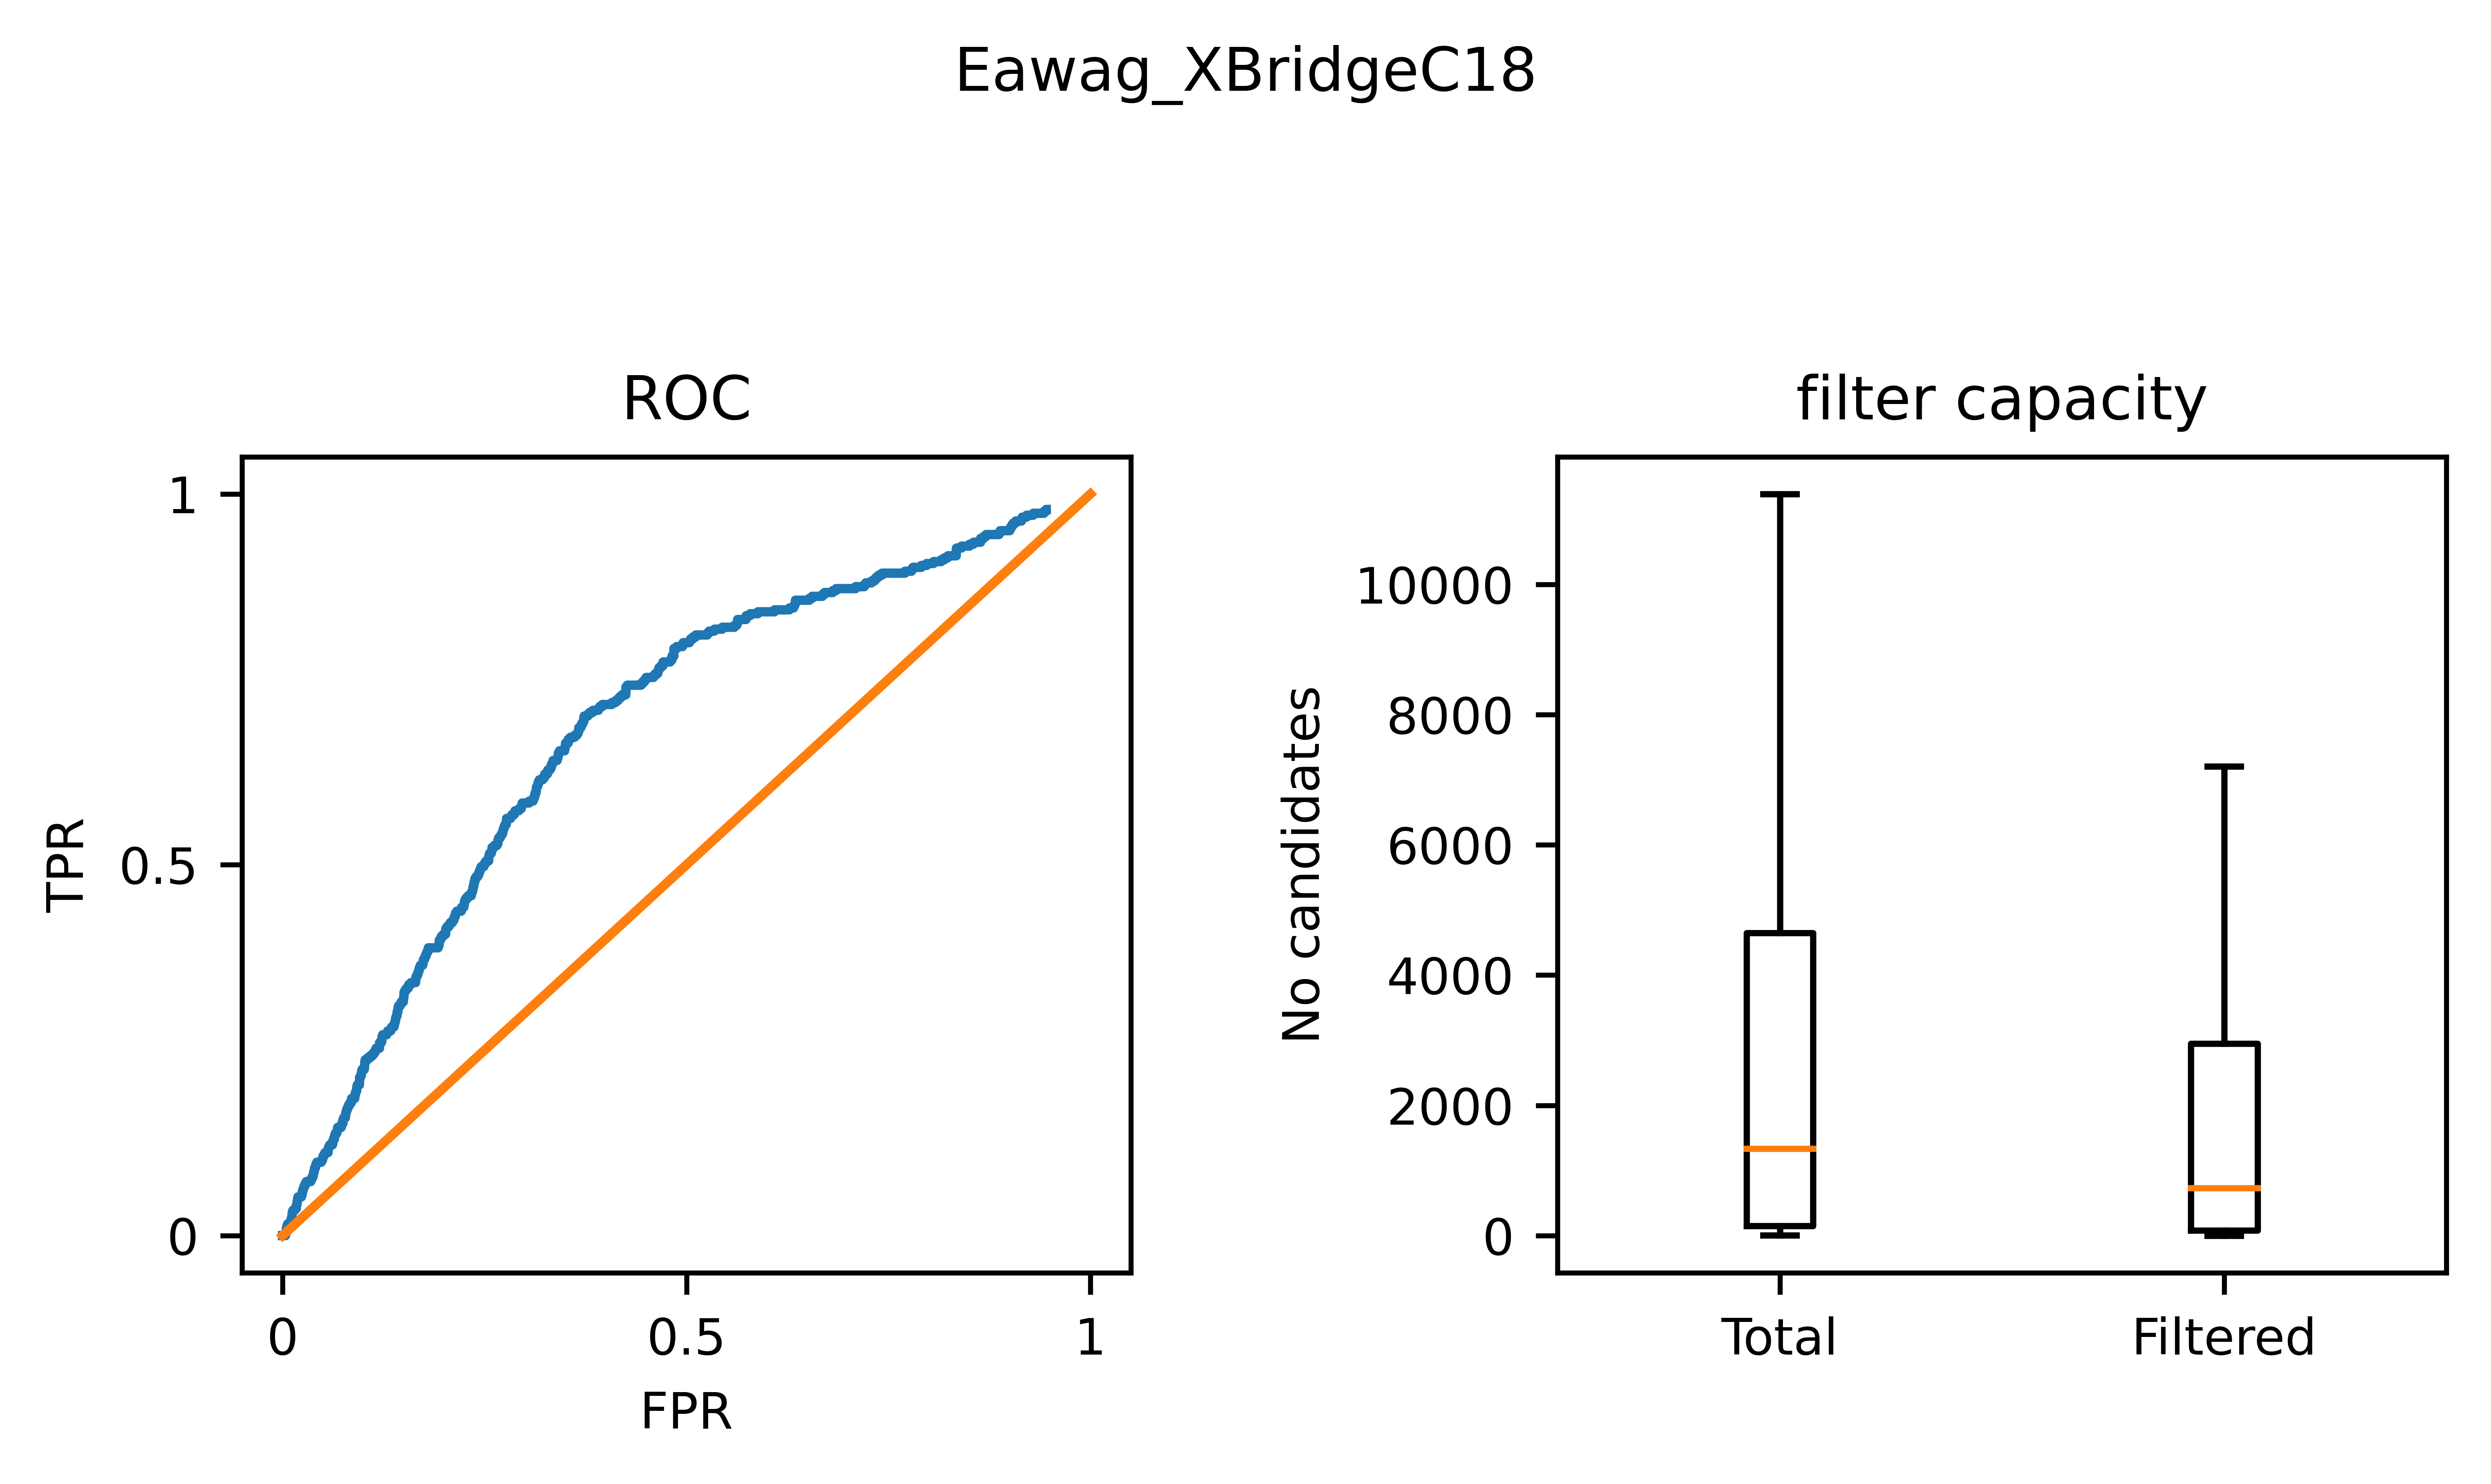

In [47]:
import matplotlib
x=[0,1]
y=[0,1]
labels=['Total', 'Filtered']
fig, axs = plt.subplots(1,2, figsize=(6, 3.5), sharey=False, dpi=1200)
i=0
matplotlib.rcParams.update({'font.size': 8})

axs[0].plot(FPR, TPR)
axs[0].plot(x,y)
axs[0].set_yticks([0,0.5, 1])
axs[0].set_xticks([0,0.5, 1])
axs[0].set_xlabel('FPR')
axs[0].set_ylabel('TPR')
axs[0].set_yticklabels(['0', '0.5', '1'])
axs[0].set_xticklabels(['0', '0.5', '1'])
axs[0].set_title('ROC')


axs[1].boxplot((total, filtered), showfliers=False)
axs[1].set_xticklabels(labels, fontsize=8)
axs[1].set_ylabel('No candidates')
axs[1].set_title('filter capacity')

fig.suptitle('Eawag_XBridgeC18')
fig.tight_layout(pad=3.0)


In [48]:
np.divide(filtered,total).mean()

0.5771487510535032

In [49]:
plt.savefig('./figs/Eawag_XBridgeC18.svg')

<Figure size 640x480 with 0 Axes>

In [ ]:
import os
import paddle
import copy
import paddle.nn as nn
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import tqdm
from paddle import optimizer
from modules import UNet_conditional, EMA
import logging
import numpy as np
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

class Diffusion:
    def __init__(self, noise_steps=500, beta_start=1e-4, beta_end=0.02, img_size=256, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.prepare_noise_schedule()
        self.alpha = 1. - self.beta
        self.alpha_hat = paddle.cumprod(self.alpha, dim=0)

        self.img_size = img_size
        self.device = device

    def prepare_noise_schedule(self):
        return paddle.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = paddle.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = paddle.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = paddle.randn(shape=x.shape)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return paddle.randint(low=1, high=self.noise_steps, shape=(n,))

    def sample(self, model, n, labels, cfg_scale=3):
        logging.info(f"Sampling {n} new images....")
        model.eval()
        with paddle.no_grad():
            x = paddle.randn((n, 3, self.img_size, self.img_size))
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = paddle.to_tensor([i] * x.shape[0]).astype("int64")
                predicted_noise = model(x, t, labels)
                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None)
                    cfg_scale = paddle.to_tensor(cfg_scale).astype("float32")
                    predicted_noise = paddle.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
             